In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [12]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [13]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [14]:
df.shape

(1599999, 6)

In [15]:
df.describe()

,0,1467810369
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [19]:
df.columns = ["target", "ids", "date", "flag", "user", "text"]

In [20]:
# Map Sentiment Values (0 = negative, 2 = neutral, 4 = positive)
df["target"] = df["target"].map({0: 0, 2: 1, 4: 2})

In [22]:
# Text Cleaning Function 
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"\@w+|\#", '', text)                 # remove mentions/hashtags
    text = re.sub(r"[^\w\s]", '', text)                 # remove punctuations
    text = re.sub(r"\d+", '', text)                     # remove digits
    text = text.strip()
    return text

# Clean the tweet text
df["clean_text"] = df["text"].apply(clean_text)

In [24]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X = df["clean_text"]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [28]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [29]:
# Predict and Evaluate
y_pred = model.predict(X_test_tfidf)


✅ Accuracy: 0.79105

📄 Classification Report:

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79    159494
     Neutral       0.00      0.00      0.00         0
    Positive       0.78      0.80      0.79    160506

   micro avg       0.79      0.79      0.79    320000
   macro avg       0.53      0.53      0.53    320000
weighted avg       0.79      0.79      0.79    320000


🔢 Confusion Matrix:
 [[123989      0  35505]
 [     0      0      0]
 [ 31359      0 129147]]


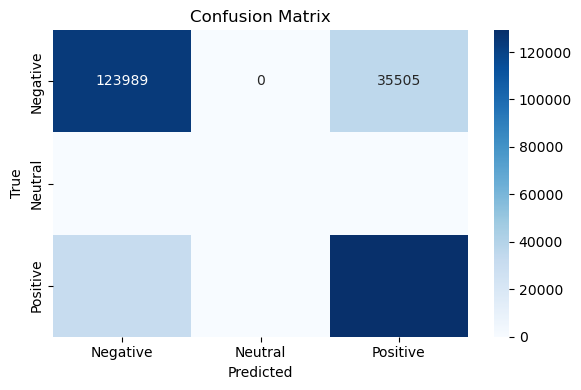

In [31]:
# ✅ Evaluation Results
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define full label list and matching names
label_ids = [0, 1, 2]  # 0 = Negative, 1 = Neutral, 2 = Positive
label_names = ["Negative", "Neutral", "Positive"]

# Accuracy
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report with fixed label set
print("\n📄 Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    labels=label_ids,
    target_names=label_names,
    zero_division=0
))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=label_ids)
print("\n🔢 Confusion Matrix:\n", conf_matrix)

# 📊 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [76]:
# 2. Tokenization
MAX_WORDS = 10000      # Use top 10,000 words from vocabulary
MAX_LEN = 50           # Pad/truncate all tweets to 50 words

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert tweets to sequences of integers
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences to make them equal length
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [77]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']  # ensures balanced class distribution
)

In [78]:
# 4. Define LSTM Model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes: 0=neg, 1=neutral, 2=positive
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Show model architecture
model.summary()

/usr/local/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:
# 5. Train model
model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

Epoch 1/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 332s 37ms/step - accuracy: 0.5455 - loss: 0.6630 - val_accuracy: 0.8073 - val_loss: 0.4168
Epoch 2/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 338s 38ms/step - accuracy: 0.8141 - loss: 0.4091 - val_accuracy: 0.8187 - val_loss: 0.3995
Epoch 3/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 296s 33ms/step - accuracy: 0.8266 - loss: 0.3848 - val_accuracy: 0.8221 - val_loss: 0.3913



✅ Accuracy: 0.8209

📄 Classification Report:

              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83    160000
     Neutral       0.00      0.00      0.00         0
    Positive       0.85      0.79      0.81    160000

   micro avg       0.82      0.82      0.82    320000
   macro avg       0.55      0.55      0.55    320000
weighted avg       0.82      0.82      0.82    320000


🔢 Confusion Matrix:
 [[137046      0  22954]
 [     0      0      0]
 [ 34368      0 125632]]


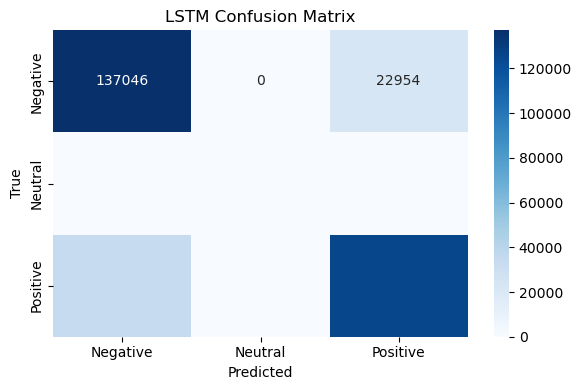

In [80]:
# 6. Evaluate
# Predicted class indices from softmax output
y_pred_classes = y_pred.argmax(axis=1)

# Define full class labels and names
label_ids = [0, 1, 2]
label_names = ["Negative", "Neutral", "Positive"]

# ✅ Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\n✅ Accuracy: {accuracy:.4f}")

# 📄 Classification Report
print("\n📄 Classification Report:\n")
print(classification_report(
    y_test,
    y_pred_classes,
    labels=label_ids,
    target_names=label_names,
    zero_division=0
))

# 🔢 Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=label_ids)
print("\n🔢 Confusion Matrix:\n", conf_matrix)

# 📊 Plot and Save Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM Confusion Matrix")
plt.tight_layout()
plt.savefig("lstm_confusion_matrix.png")
plt.show()

In [81]:
def predict_sentiment(text):
    # 1. Clean the text
    cleaned_text = clean_text(text)

    # 2. Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

    # 3. Predict
    pred = model.predict(padded)
    class_idx = pred.argmax(axis=1)[0]

    # 4. Interpret result
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    confidence = round(pred[0][class_idx] * 100, 2)

    print(f"\n📝 Input: {text}")
    print(f"🔍 Sentiment: {label_map[class_idx]} ({confidence}%)")

In [82]:
predict_sentiment("I really love this product! So happy.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step

📝 Input: I really love this product! So happy.
🔍 Sentiment: Positive (99.64%)


In [83]:
predict_sentiment("This is the worst thing I've ever bought.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

📝 Input: This is the worst thing I've ever bought.
🔍 Sentiment: Negative (95.66%)


In [84]:
predict_sentiment("It's okay, not too bad but not great either.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

📝 Input: It's okay, not too bad but not great either.
🔍 Sentiment: Negative (92.04%)


In [85]:
predict_sentiment("It tasted average")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

📝 Input: It tasted average
🔍 Sentiment: Negative (92.5%)


In [86]:
predict_sentiment("You look ugly")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

📝 Input: You look ugly
🔍 Sentiment: Negative (58.69%)


In [90]:
predict_sentiment("It is So Hot")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

📝 Input: It is So Hot
🔍 Sentiment: Negative (76.75%)
